Classifier Accuracy: 0.8445
Classifier Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82      5021
           1       0.86      0.87      0.86      6778

    accuracy                           0.84     11799
   macro avg       0.84      0.84      0.84     11799
weighted avg       0.84      0.84      0.84     11799



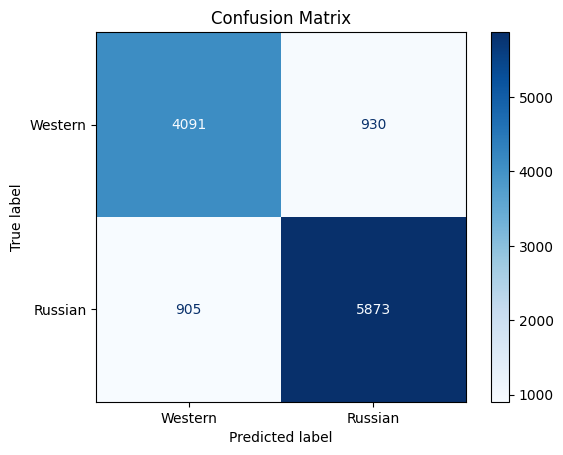

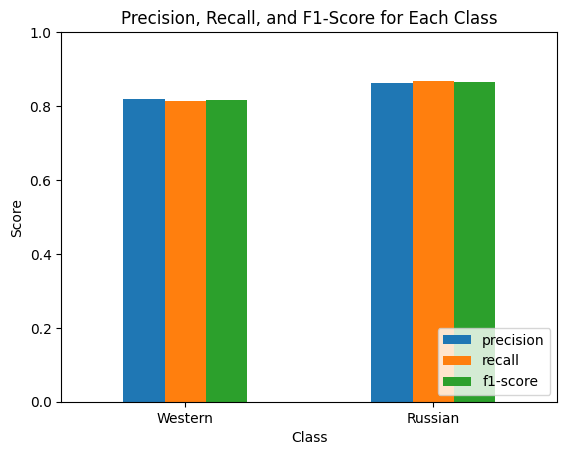

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve,  RandomizedSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix,roc_auc_score, roc_curve, ConfusionMatrixDisplay
import numpy as np
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
import warnings

#Using the data from the combined dataset
df_combined = pd.read_csv('merged_df.csv')

#using the tweets in a column named 'tweet' and labels (binary) are in a column named 'Russian'
tweets_combined = df_combined['tweet'].tolist()
labels_combined = df_combined['label'].tolist()

#Split the dataset intro training and test data
X_train, X_test, y_train, y_test = train_test_split(tweets_combined, labels_combined, test_size=0.3, random_state=42)

# using the TF-IDF vectorizer for the data to remove the common words making it into a matrix and handling the wording
vect_comb = TfidfVectorizer()

# Fit and transform into TF-IDF
tfidf_matrix = vect_comb.fit_transform(df_combined)

#Fit and transforming the data 
X_train_tfidf = vect_comb.fit_transform(X_train)
X_test_tfidf = vect_comb.transform(X_test)

#Logistic Regression model
model = LogisticRegression(solver='saga',random_state = 42, max_iter = 100, C=10)
#using the default solver lbfgs, liblinear or saga for best results

#Training the model
model.fit(X_train_tfidf, y_train)

#Prediction of the test dataset
y_pred_comb = model.predict(X_test_tfidf)

#Evaluation of the model
accuracy = accuracy_score(y_test, y_pred_comb)
report = classification_report(y_test, y_pred_comb, output_dict=True)
print(f"Classifier Accuracy: {accuracy:.4f}")
print("Classifier Report:\n", classification_report(y_test, y_pred_comb))

#Confusion matrix plotting
conf_matrix = confusion_matrix(y_test, y_pred_comb)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Western', 'Russian'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

#Extract metrics
metrics_df = pd.DataFrame(report).transpose()

#Plotting based on each class the precision, recall, and F1-score
metrics_df[['precision', 'recall', 'f1-score']].iloc[:-3].plot(kind='bar')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xlabel('Class')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(ticks=[0, 1], labels=['Western', 'Russian'], rotation=0)
plt.legend(loc='lower right')
plt.show()

In [26]:
#remove warnings
warnings.filterwarnings('ignore')

#Logistic Regression
param_grid = {
    'C': [0.1, 1, 5, 10, 20],
    'solver': ['lbfgs', 'liblinear', 'saga',],
    'max_iter': [50, 100, 500, 1000]
}

grid_search = GridSearchCV(LogisticRegression(random_state=42), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train)

print(f"Best parameters for Logistic Regression: {grid_search.best_params_}")
logistic_regression_model = grid_search.best_estimator_

#XGBoost
param_distributions = {
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

xgb_model = xgb.XGBClassifier(random_state=42)
random_search = RandomizedSearchCV(xgb_model, param_distributions, n_iter=50, scoring='accuracy', n_jobs=-1, cv=3, random_state=42)
random_search.fit(X_train_tfidf, y_train)

print(f"Best parameters for XGBoost: {random_search.best_params_}")
xgboost_model = random_search.best_estimator_

#Conclusion on both models
logistic_regression_accuracy = accuracy_score(y_test, logistic_regression_model.predict(X_test_tfidf))
xgboost_accuracy = accuracy_score(y_test, xgboost_model.predict(X_test_tfidf))

print(f"Accuracy for Logistic Regression: {logistic_regression_accuracy:.4f}")
print(f"Accuracy for XGBoost: {xgboost_accuracy:.4f}")

Best parameters for Logistic Regression: {'C': 20, 'max_iter': 50, 'solver': 'saga'}
Best parameters for XGBoost: {'max_depth': 5, 'learning_rate': 0.2}
Accuracy for Logistic Regression: 0.8430
Accuracy for XGBoost: 0.7806


In [35]:
warnings.filterwarnings('ignore')

X_train_tfidf = vect_comb.fit_transform(X_train)
X_test_tfidf = vect_comb.transform(X_test)


def g_search(Model, param_distributions, X_train, y_train, crossfolds=5, n_iter=10):
    # Perform randomized search
    randomized_search = RandomizedSearchCV(Model, param_distributions, cv=crossfolds, n_iter=n_iter, scoring='accuracy', random_state=42)
    randomized_search.fit(X_train, y_train)
    print("Best parameters:", randomized_search.best_params_)
    best_model = randomized_search.best_estimator_
    return best_model

def train_model(Model, X_train, y_train):
    # Fit the model
    Model.fit(X_train, y_train)
    return Model

def analyse_model(Model, Name, X_test, y_test):
    # Return classification report
    predictions = Model.predict(X_test)
    print(Name)
    print(classification_report(y_test, predictions))

def plot_lc(Model, X_train, y_train, Name):
    train_sizes, train_accuracy, test_accuracy = learning_curve(Model, X_train, y_train, cv=5)
    plt.figure()
    plt.plot(train_sizes, train_accuracy.mean(axis=1), label='Training accuracy')
    plt.plot(train_sizes, test_accuracy.mean(axis=1), label='Test accuracy')
    plt.title(f"Learning Curve for {Name}")
    plt.xlabel('Training')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(f'Learning Curve for {Name}.png')
    plt.clf()

def plot_roc_curve(Model, X_test, y_test, Name):
    probs = Model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)
    plt.figure()
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"ROC Curve for {Name}")
    plt.legend(loc='best')
    plt.grid()
    plt.savefig(f'ROC Curve for {Name}.png')
    plt.clf()

def expand_model(BaseModel, ADABOOST):
    models = [BaseModel]
    if ADABOOST:
        models.append(AdaBoostClassifier(estimator=BaseModel, n_estimators=50, algorithm='SAMME', random_state=42))
    return models

def do_model(BaseModel, Names, X_train, y_train, X_test, y_test, LC=1, ROC=1, ADABOOST=1, Expand=1):
    i = 0
    if Expand == 1:
        for model in expand_model(BaseModel, ADABOOST):
            print(f'Doing model {Names[i]}')
            model = train_model(model, X_train, y_train)
            analyse_model(model, Names[i], X_test, y_test)
            if LC == 1:
                plot_lc(model, X_train, y_train, Names[i])
            if ROC == 1:
                plot_roc_curve(model, X_test, y_test, Names[i])
            i += 1
    else:
        print(f'Doing model {Names[i]}')
        model = train_model(BaseModel, X_train, y_train)
        analyse_model(model, Names[i], X_test, y_test)
        if LC == 1:
            plot_lc(model, X_train, y_train, Names[i])
        if ROC == 1:
            plot_roc_curve(model, X_test, y_test, Names[i])
        i += 1

# Example usage
param_distributions = [
    {'C': [0.1, 1, 10]},  # used in LR model, C = inverse regularization strength, numbers are either low C, Middle C or high C
    {'learning_rate': [0.05, 0.1, 0.2]},  # used in AdaBoost
    {'max_depth': [3, 4, 5]}  # used in tree-based models (if needed)
]
logistic_regression = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
best_model = g_search(logistic_regression, param_distributions[0], X_train_tfidf, y_train)

# Perform model training and analysis
do_model(best_model, ['Logistic Regression', 'AdaBoost with Logistic Regression'], X_train_tfidf, y_train, X_test_tfidf, y_test)


Best parameters: {'C': 10}
Doing model Logistic Regression
Logistic Regression
              precision    recall  f1-score   support

           0       0.82      0.81      0.82      5021
           1       0.86      0.87      0.86      6778

    accuracy                           0.84     11799
   macro avg       0.84      0.84      0.84     11799
weighted avg       0.84      0.84      0.84     11799

Doing model AdaBoost with Logistic Regression
AdaBoost with Logistic Regression
              precision    recall  f1-score   support

           0       0.75      0.81      0.78      5021
           1       0.85      0.80      0.82      6778

    accuracy                           0.80     11799
   macro avg       0.80      0.80      0.80     11799
weighted avg       0.81      0.80      0.80     11799



<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [ ]:
# Define sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Visualize with a selected feature from TF-IDF features
x_feat_index = 0
x_feat = vect_comb.get_feature_names_out()[x_feat_index]

# Extract the feature for visualization
X_test_feat = X_test_tfidf[:, x_feat_index].toarray().ravel()

# Generate a range of x values and compute corresponding y values (probability)
x_range = np.linspace(X_test_feat.min(), X_test_feat.max(), 300)

# Create an input matrix with the mean values for all features except the selected one
X_range_matrix = np.zeros((len(x_range), X_test_tfidf.shape[1]))
X_range_matrix[:, x_feat_index] = x_range

# Compute z values (decision function) for this range
z_range = np.dot(X_range_matrix, model.coef_.T) + model.intercept_

# Apply the sigmoid function to these z values to get probabilities
y_range_proba = sigmoid(z_range).ravel()

# Making predictions on the test set with selected features
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

# Visualize the sigmoid function for the test data with selected features
plt.figure(figsize=(10, 6))
plt.scatter(X_test_feat, y_pred_proba, color='blue', label='Predicted Probability')
plt.scatter(X_test_feat, y_test, color='red', marker='x', label='Actual Test Data')
plt.plot(x_range, y_range_proba, color='green', label='Sigmoid Function Line')
plt.title('Logistic Regression Predictions with Selected Features')
plt.xlabel(f'TF-IDF Feature Value for {x_feat}')
plt.ylabel('Probability of Being Russian Tweet')
plt.legend()
plt.show()


In [4]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Load the combined CSV file
df_combined = pd.read_csv('merged_df.csv')

# Extract tweets
tweets_combined = df_combined['tweet']

# Define a list of common stop words to remove
stop_words = set([
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves',
    'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them',
    'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am',
    'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did',
    'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by',
    'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above',
    'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then',
    'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most',
    'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't',
    'can', 'will', 'just', 'don', 'should', 'now', 'the', 'of', 'co', 'https', 'to', 'in', 'and', 'is', 'that'
])

# Convert the stop words set to a list
stop_words_list = list(stop_words)

# Define a CountVectorizer with specified stop words
count_vectorizer = CountVectorizer(stop_words=stop_words_list)

# Transform the tweets into a document-term matrix
X_counts = count_vectorizer.fit_transform(tweets_combined)

# Sum the frequencies of each word
word_freq = X_counts.sum(axis=0)

# Get the feature names (words)
words = count_vectorizer.get_feature_names_out()

# Create a dictionary of word frequencies
word_freq_dict = dict(zip(words, word_freq.tolist()[0]))

# Sort the word frequencies in descending order
sorted_word_freq = sorted(word_freq_dict.items(), key=lambda x: x[1], reverse=True)

# Take the top 10 most frequent words
top_10_words = sorted_word_freq[:10]

# Print the top 10 most frequent words
print("Top 10 most frequent words (excluding common stop words):")
for word, freq in top_10_words:
    print(f"{word}: {freq}")

Top 10 most frequent words (excluding common stop words):
russian: 8173
ukraine: 7864
russia: 5006
ukrainian: 3744
forces: 2498
war: 2215
people: 2113
us: 2104
military: 2069
one: 1647
